# Import libraries

In [278]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import profile_report
import seaborn as sns
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

from src.utils import *

from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
import shap

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# import data

In [279]:
main_folder='data'
file_name='diabetic_data.csv'
file_path=os.path.join(main_folder,file_name)

df=pd.read_csv(file_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# EDA

In [280]:
profile=df.profile_report(
        title='Pandas profiling Report',
        correlations={'spearman':{'calculate':True},
        'pearson':{'calculate':True}},
        interactions={'targets':['readmitted'],'continuous':True}
        #,minimal=True
        ,explorative=True
        )

In [281]:
# profile.to_file('readmitted_profiling.html')

# Feature Engineering

## Deal with missing values

In [282]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [283]:
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())
         df[col]=np.where(df[col]=='?',np.nan,df[col])

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [284]:
# gender was coded differently so we use a custom count for this one            
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())
df['gender']=np.where(df['gender']=='Unknown/Invalid',np.nan,df['gender'])     

gender 3


"**Weight**" is missing in over 98% records. "**Payer code**" and "**Medical specialty**" also have 40-50% missing values. The best thing is to drop them because the poor interpretability and little predictive generalizability to patients. However, for the last two mentioned columns we create a flag to point out that was null

In [285]:
for col in ['payer_code','medical_specialty','max_glu_serum','A1Cresult']:
    df['flag_null_'+col]=np.where(df[col].isnull(),1,0)

df.drop(columns=['weight','payer_code','medical_specialty'],inplace=True)
df['max_glu_serum']=df['max_glu_serum'].fillna('Other')
df['A1Cresult']=df['A1Cresult'].fillna('Other')

## Drop columns and rows

Remove the "**Encounter ID**" and keep the "**Patient number**". This is because some patients in the dataset may had more than one encounters and only the patient number is unique.<br>

Delete columns "diag_2", "diag_3", only use the primary diagnosis(diag_1)

In [286]:
df.drop(columns=['encounter_id','diag_2','diag_3'],inplace=True)

Two medications named “Citoglipton” and “Examide” were deleted because all records have the same value.

In [287]:
df.drop(columns=['examide','citoglipton'],inplace=True)

Remove missing value--"race","gender","diag_1"

In [288]:
df = df.dropna(subset=['race', 'gender', 'diag_1'])

## Transforming category columns

Basing on some common sense: Since the objective is to predict readmissions, those patients who died during this hospital admission were excluded. Encounters with “Discharge disposition” values of 11, 13, 14, 19, 20, or 21 are related to death or hospice which mean these patients cannot be readmitted.

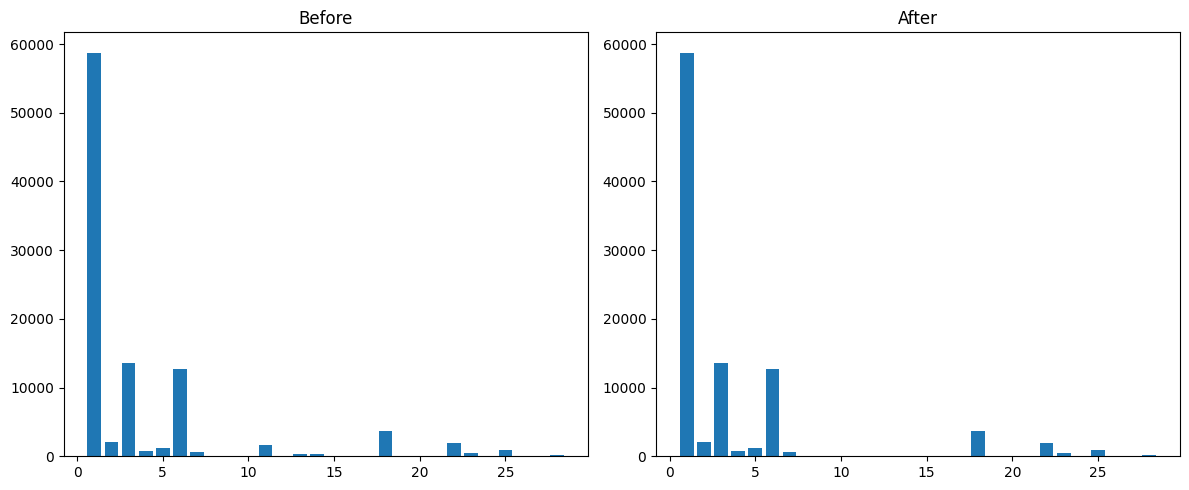

In [289]:
# Create subplots with 1 row and 2 columns
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# Create a bar plot for 'discharge_disposition_id' before filtering
before_counts = df['discharge_disposition_id'].value_counts()
plt.bar(before_counts.index, before_counts.values)
plt.title('Before')

# Define the IDs to remove
ids_to_remove = [11, 13, 14, 19, 20, 21]

# Filter the DataFrame to remove rows with specified IDs
df = df[~df['discharge_disposition_id'].isin(ids_to_remove)]

# Create a bar plot for 'discharge_disposition_id' after filtering
plt.subplot(1, 2, 2)
after_counts = df['discharge_disposition_id'].value_counts()
plt.bar(after_counts.index, after_counts.values)
plt.title('After')

plt.tight_layout()
plt.show()

In [290]:
df.rename(columns={'admission_type_id': 'admission_type'}, inplace=True)

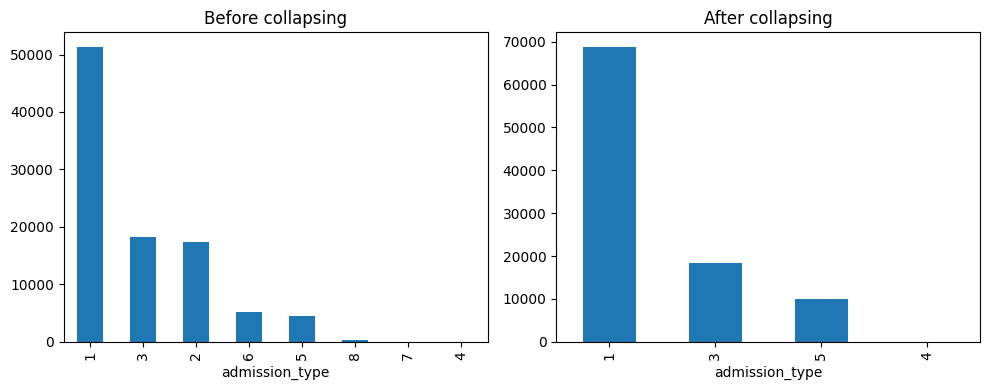

In [291]:
# Create a bar plot for 'admission_type' before collapsing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['admission_type'].value_counts().plot(kind='bar')
plt.title('Before collapsing')

# Collapsing some values in 'admission_type'
df['admission_type'].replace({2: 1, 7: 1, 6: 5, 8: 5}, inplace=True)

# Create a bar plot for 'admission_type' after collapsing
plt.subplot(1, 2, 2)
df['admission_type'].value_counts().plot(kind='bar')
plt.title('After collapsing')

plt.tight_layout()
plt.show()

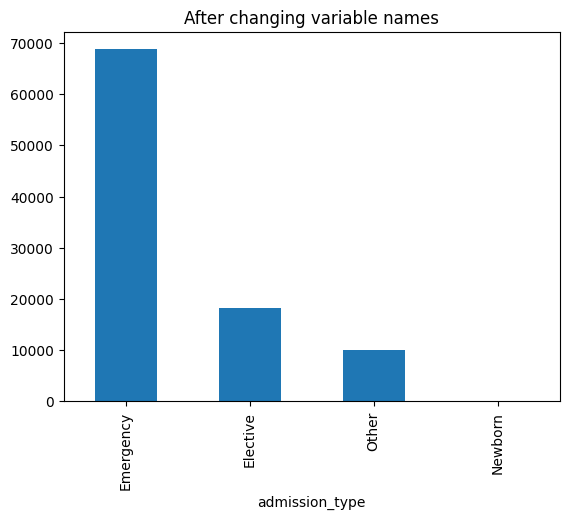

In [292]:
# Change the names of variables
df['admission_type'] = df['admission_type'].replace({1: 'Emergency', 5: 'Other', 3: 'Elective', 4: 'Newborn'})

# Create a bar plot for 'admission_type' after changing variable names
df['admission_type'].value_counts().plot(kind='bar')
plt.title('After changing variable names')
plt.show()

Text(0.5, 1.0, 'Before collapsing')

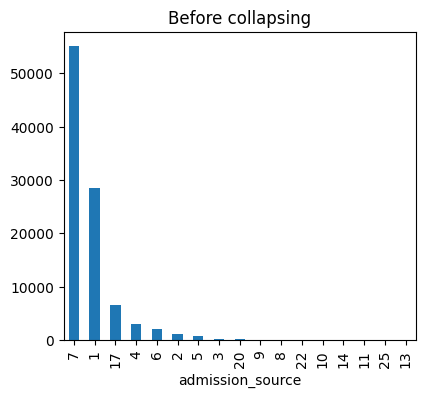

In [293]:
# Change the name of the column 'admission_source_id' to 'admission_source'
df.rename(columns={'admission_source_id': 'admission_source'}, inplace=True)

# Create a bar plot for 'admission_source' before collapsing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['admission_source'].value_counts().plot(kind='bar')
plt.title('Before collapsing')

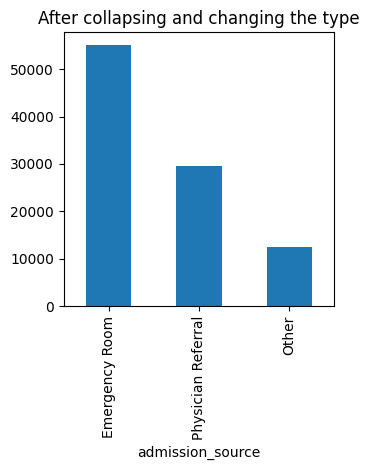

In [294]:
# Collapsing values and changing variable names
df['admission_source'] = np.where(df['admission_source'].isin([1,2,3]),
                                  "Physician Referral",
                        np.where(
                            df['admission_source'].isin([4,5,6,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26]),
                            "Other",
                            "Emergency Room"
                        ))

# Create a bar plot for 'admission_source' after collapsing and changing the type
plt.subplot(1, 2, 2)
df['admission_source'].value_counts().plot(kind='bar')
plt.title('After collapsing and changing the type')

plt.tight_layout()
plt.show()

In [295]:
# Change the name of the column 'discharge_disposition_id' to 'discharge_disposition'
df.rename(columns={'discharge_disposition_id': 'discharge_disposition'}, inplace=True)

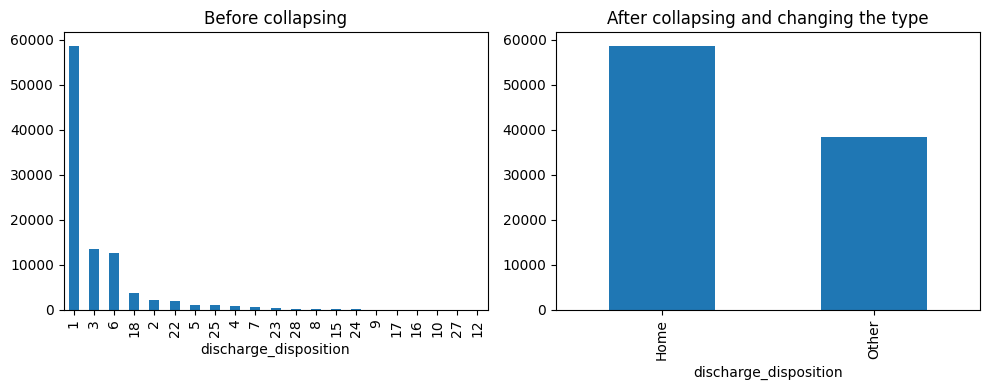

In [296]:
# Create a bar plot for 'discharge_disposition' before collapsing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['discharge_disposition'].value_counts().plot(kind='bar')
plt.title('Before collapsing')

# Collapsing values and changing variable names
df['discharge_disposition'] = np.where(df['discharge_disposition']==1,'Home','Other')

# Create a bar plot for 'discharge_disposition' after collapsing and changing the type
plt.subplot(1, 2, 2)
df['discharge_disposition'].value_counts().plot(kind='bar')
plt.title('After collapsing and changing the type')

plt.tight_layout()
plt.show()

## Categorization

The **'diag_1'** contained three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700-900 unique ICD codes and it is extremely difficult to include them in the model and interpret them meaningfully. Therefore, these diagnosis codes were collapsed into 9 disease categories, which include Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others (See Table below) 
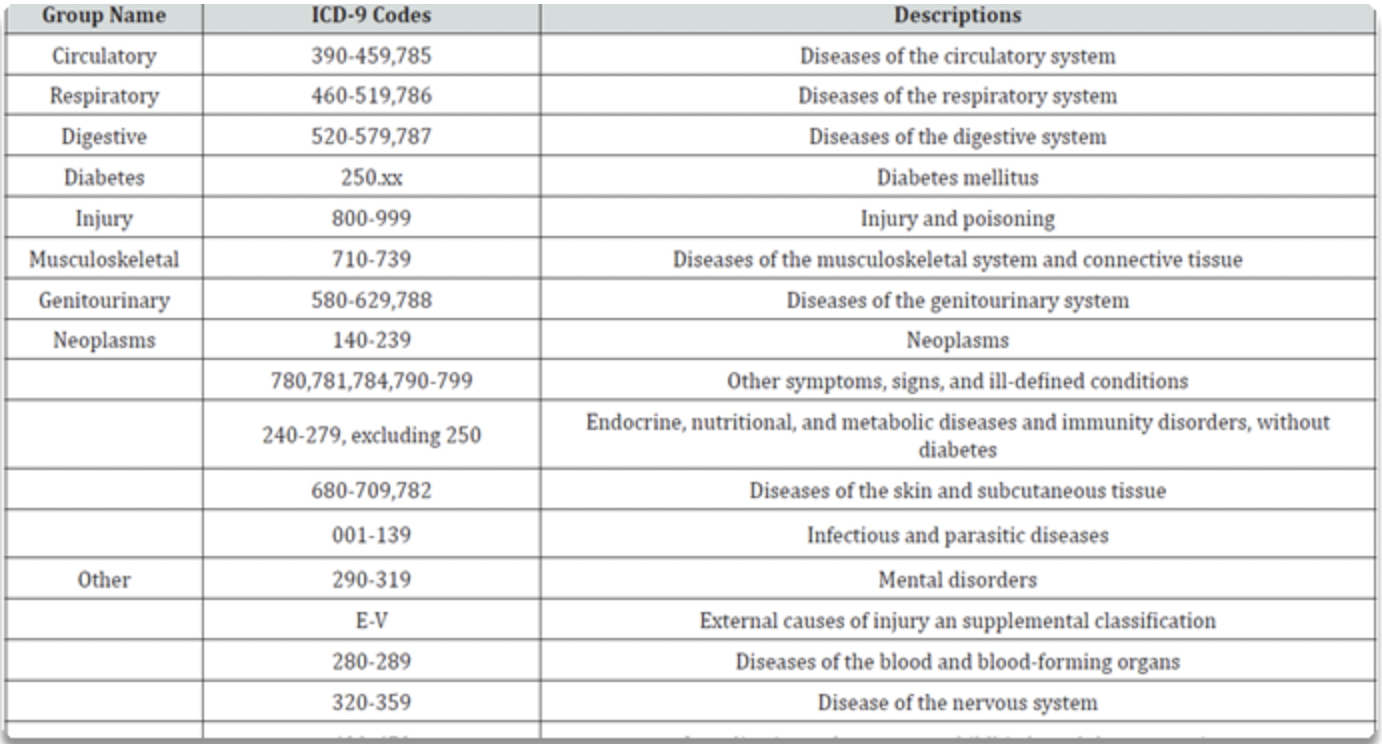

In [297]:
# Convert 'diag_1' to a character type
df['diag_1'] = df['diag_1'].astype(str)

# Apply the categorize_diagnosis function to create a new column 'primary_diagnosis'
df['primary_diagnosis'] = df['diag_1'].apply(categorize_diagnosis)

In [298]:
df.primary_diagnosis.value_counts()

primary_diagnosis
Circulatory        29011
Other              17354
Respiratory        13626
Digestive           9155
Diabetes            8472
Injury              6702
Genitourinary       4912
Musculoskeletal     4804
Neoplasms           3054
Name: count, dtype: int64

In [299]:
df.drop(columns=['diag_1'],inplace=True)

Regrouping the age.

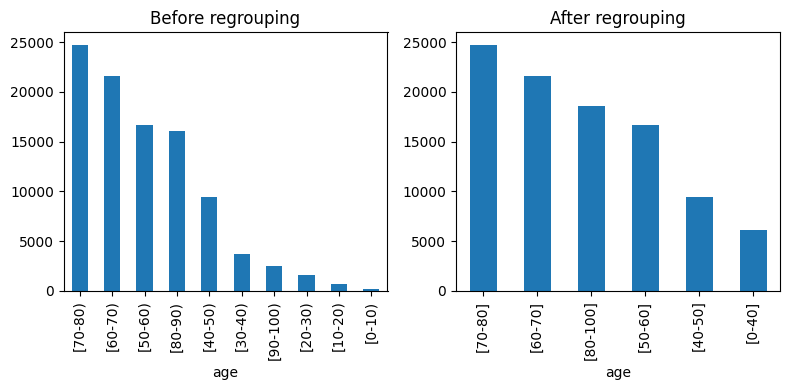

In [300]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
df['age'].value_counts().plot(kind='bar')
plt.title('Before regrouping')

# Regroup the 'age' column using NumPy's where function
df['age'] = np.where(df['age'].isin(["[0-10)", "[10-20)", "[20-30)", "[30-40)"]), "[0-40]",
                     np.where(df['age'].isin(["[80-90)", "[90-100)"]), "[80-100]",
                              np.where(df['age'] == "[40-50)", "[40-50]",
                                       np.where(df['age'] == "[50-60)", "[50-60]",
                                                np.where(df['age'] == "[60-70)", "[60-70]", "[70-80]")))))

# Create a bar plot for 'age' after regrouping
plt.subplot(1, 2, 2)
df['age'].value_counts().plot(kind='bar')
plt.title('After regrouping')

plt.tight_layout()
plt.show()

Number of medication used: Another possibly related factor could be the total number of medications used by the patient (which may indicate severity of their condition and/or the intensity of care). So we created another feature by counting the medications used during the encounter (keys variable in code below is continued from above):

There are some future medications which has almost a constant value, let's drop them

In [301]:
feat_medi_drop=[
    'repaglinide',
    'nateglinide',
    'chlorpropamide',
    'acetohexamide',
    'tolbutamide',
    'acarbose',
    'miglitol',
    'troglitazone',
    'tolazamide',
    'glyburide-metformin',
    'glipizide-metformin',
    'glimepiride-pioglitazone',
    'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

df.drop(columns=feat_medi_drop,inplace=True)

In [302]:
#categorize "readmitted" to 1 --patient was readmitted within 30 days, 0-- readmission after 30 days and no readmission
df['readmitted'] = np.where(df['readmitted'].isin([">30", "NO"]), 0, 1)

Collapsing of Multiple Encounters for same patient Some patients in the dataset had more than one encounter.We could not count them as independent encounters because that bias the results towards those patients who had multiple encounters. Thus we tried multiple techniques to collapse and consolidate multiple encounters for same patient such as:

- Considering more than 2 readmissions across multiple encounters as readmission for collapsed record.
- Considering average stay at hospital across multiple encounters.
- Considering the percentage of the medication changes across multiple encounters
- Considering the total number of the encounters to replace the encounter unique ID
- Considering the combination of diagnoses across multiple encounters as a list However, taking the features such as “diagnosis”, for instance, we did not find it not meaningful to combine multiple categorical values into an array for building data model. We then considered first encounter and last encounter separately as possible representations of multiple encounters. However, last encounters gave extremely imbalanced data for readmissions (96/4 Readmissions vs No Readmissions) and thus, we decided to use first encounters of patients with multiple encounters. This resulted in dataset being reduced to about 70,000 encounters:

In [303]:
df.drop_duplicates(subset= ['patient_nbr'], keep = 'first',inplace=True)

# Drop the 'patient_nbr' column
df.drop(columns=['patient_nbr'], inplace=True)

## Remove outliers

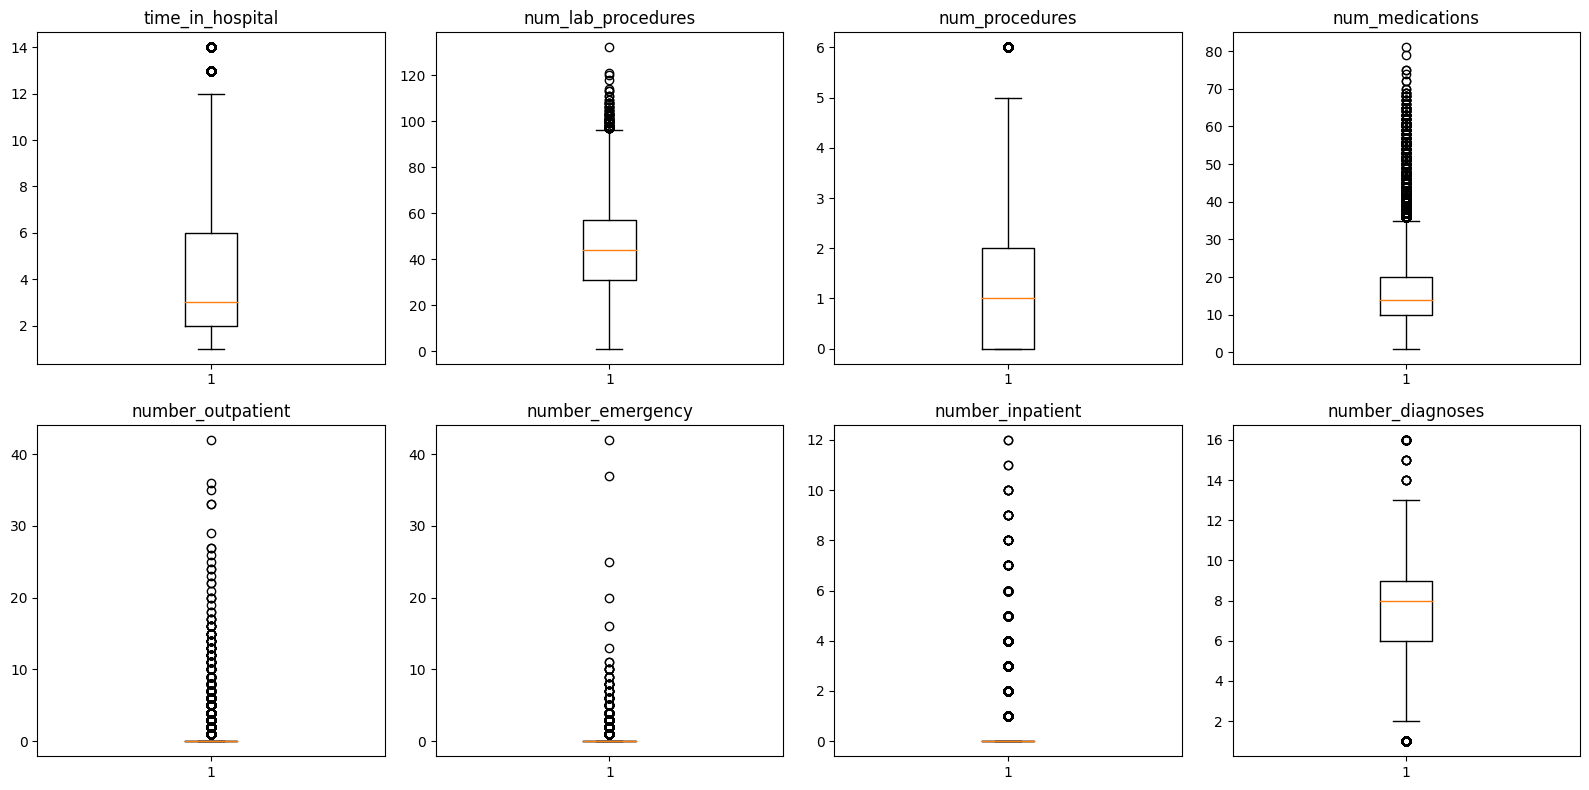

In [304]:
# Create subplots with 2 rows and 4 columns
plt.figure(figsize=(16, 8))
plt.subplot(2, 4, 1)
plt.boxplot(df['time_in_hospital'])
plt.title('time_in_hospital')

plt.subplot(2, 4, 2)
plt.boxplot(df['num_lab_procedures'])
plt.title('num_lab_procedures')

plt.subplot(2, 4, 3)
plt.boxplot(df['num_procedures'])
plt.title('num_procedures')

plt.subplot(2, 4, 4)
plt.boxplot(df['num_medications'])
plt.title('num_medications')

plt.subplot(2, 4, 5)
plt.boxplot(df['number_outpatient'])
plt.title('number_outpatient')

plt.subplot(2, 4, 6)
plt.boxplot(df['number_emergency'])
plt.title('number_emergency')

plt.subplot(2, 4, 7)
plt.boxplot(df['number_inpatient'])
plt.title('number_inpatient')

plt.subplot(2, 4, 8)
plt.boxplot(df['number_diagnoses'])
plt.title('number_diagnoses')

plt.tight_layout()
plt.show()

Drop columns full of outliers

In [305]:
df.drop(columns=['number_outpatient','number_emergency','number_inpatient'],inplace=True)

In [307]:
flag_null_columns = [col for col in df.columns if 'flag_null' in col]

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68158 entries, 0 to 101765
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   race                         68158 non-null  object
 1   gender                       68158 non-null  object
 2   age                          68158 non-null  object
 3   admission_type               68158 non-null  object
 4   discharge_disposition        68158 non-null  object
 5   admission_source             68158 non-null  object
 6   time_in_hospital             68158 non-null  int64 
 7   num_lab_procedures           68158 non-null  int64 
 8   num_procedures               68158 non-null  int64 
 9   num_medications              68158 non-null  int64 
 10  number_diagnoses             68158 non-null  int64 
 11  max_glu_serum                68158 non-null  object
 12  A1Cresult                    68158 non-null  object
 13  metformin                    68158 

In [310]:
category_columns=df.select_dtypes(include=['object']).columns
category_columns

Index(['race', 'gender', 'age', 'admission_type', 'discharge_disposition',
       'admission_source', 'max_glu_serum', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed',
       'primary_diagnosis'],
      dtype='object')

In [311]:
df=pd.get_dummies(df,prefix=category_columns,
                    columns = category_columns, drop_first=True)

In [312]:
df.rename(columns={'readmitted':'target'},inplace=True)

In [313]:
df.columns = df.columns.str.replace(r'\[|\]|-|>|<', '_', regex=True)

In [314]:
df.to_csv('data/out/df_final.csv',index=False)

In [315]:
category_columns_final=[col for col in df.columns for dummy_column in category_columns if dummy_column in col]+flag_null_columns

with open("data/category_columns.pkl", "wb") as f:
    pickle.dump(category_columns_final, f)